# Recurrent Neural Network for my MS-DS 5511 Deep Learning Course

## Project Overview / Description

We are gathered here today to complete the final project for a course in Deep Learning. We can choose any area we want, and my focus is on using Recurrent Neural Networks (RNN) for Time-series foreccasting. While we did a similar thing for classifying tweets, this project focusses on time series stock data. I am used to time series data, but have yet to combine it with any ML stuff (specifically tensorflow). Let's dive in and see if we can't forecast what the stock price will be leveraging historical data pulled directly from yahoo finance.
<br><br>
It's also important to apply business context whenever possible, for that matter we will perform some "feature engineering" to pull more data form our limited yahoo supplied data.
<br><br>

*Quick notes / Disclaimers :*

The work in this notebook leverages many who have come before! Specifically, I am directly leveraging [the tensorflow docs](https://www.tensorflow.org/tutorials/structured_data/time_series) but using stock price data instead of weather data. You will see a lot of similarities.

So let's get started!
<br><br>

## Steps:
### 1. Gather the Data
### 2. Perform basic EDA
### 3. Model Architecture and Training
### 4. Results and Analysis
### 5. Conclusion


## Step 1: (after some imports) Connect to the yahoo finance and download some historical data!


In [1]:
# some general imports
import IPython
import IPython.display
from warnings import filterwarnings
filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import pickle

print('imports complete')

imports complete


In [2]:
# import data

import yfinance as yf

# Get the data for the stock WDAY
data = yf.download('WDAY','2003-07-25','2023-09-01')

# quick feature engineering
# calc proxy for daily volatility
data['movement'] = data['Close'] - data['Open']
data['spread'] = data['High']-data['Low']
# calc proxy for current events that may impact the stock
data['moving_5'] = data['Close'].rolling(5, min_periods = 1, axis = 0).mean()
data['moving_20'] = data['Close'].rolling(20, min_periods = 1, axis = 0).mean()
data['moving_60'] = data['Close'].rolling(60, min_periods = 1, axis = 0).mean()

# reduce our data down to our engineered columns
data = data[['Close','spread', 'movement', 'Volume','moving_5','moving_20','moving_60']]

print(data.shape)

data.head()

[*********************100%***********************]  1 of 1 completed
(2719, 7)


,Close,spread,movement,Volume,moving_5,moving_20,moving_60
Date,,,,,,,
2012-10-12,48.689999,6.320000,0.639999,18132800,48.689999,48.689999,48.689999
2012-10-15,51.939999,4.400002,3.199997,3091900,50.314999,50.314999,50.314999
2012-10-16,52.160000,1.590000,-1.330002,805200,50.929999,50.929999,50.929999
2012-10-17,55.410000,5.209999,3.389999,1386400,52.049999,52.049999,52.049999
2012-10-18,53.419998,4.230000,-1.660004,1523300,52.323999,52.323999,52.323999


### ^^^ EDA Part 1

Look at the size of our data! So many days since Workday has gone public. It's also important to note that the original columns were Close, Open, High, Low, and Volume and I have removed the bulk of these with our engineered columns.

Also, the index column of the returned dataframe is the date of the record.

## Step 2 : Perform EDA

Let's check out our data even more. Because the context here is a stock, we expect to have daily records. Let's see what the yahoo python module returns! It should all be pretty straight forward.

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-10-12 to 2023-08-04
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      2719 non-null   float64
 1   spread     2719 non-null   float64
 2   movement   2719 non-null   float64
 3   Volume     2719 non-null   int64  
 4   moving_5   2719 non-null   float64
 5   moving_20  2719 non-null   float64
 6   moving_60  2719 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 169.9 KB


In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,2719.0,1.369572e+02,6.382713e+01,46.990002,8.192500e+01,1.233700e+02,1.871850e+02,3.009000e+02
spread,2719.0,4.260758e+00,2.904801e+00,0.480000,2.079994e+00,3.470001e+00,5.639999e+00,2.139000e+01
movement,2719.0,5.126523e-02,3.031522e+00,-16.429993,-1.229996e+00,1.200027e-01,1.470001e+00,1.886002e+01
Volume,2719.0,1.813547e+06,1.346648e+06,109300.000000,1.073750e+06,1.521800e+06,2.148600e+06,2.315390e+07
moving_5,2719.0,1.368243e+02,6.373699e+01,47.460001,8.180600e+01,1.245840e+02,1.877420e+02,2.983760e+02
moving_20,2719.0,1.363342e+02,6.347596e+01,48.689999,8.185625e+01,1.249765e+02,1.869110e+02,2.912205e+02
moving_60,2719.0,1.350922e+02,6.296115e+01,48.689999,8.086292e+01,1.163448e+02,1.843724e+02,2.793785e+02


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

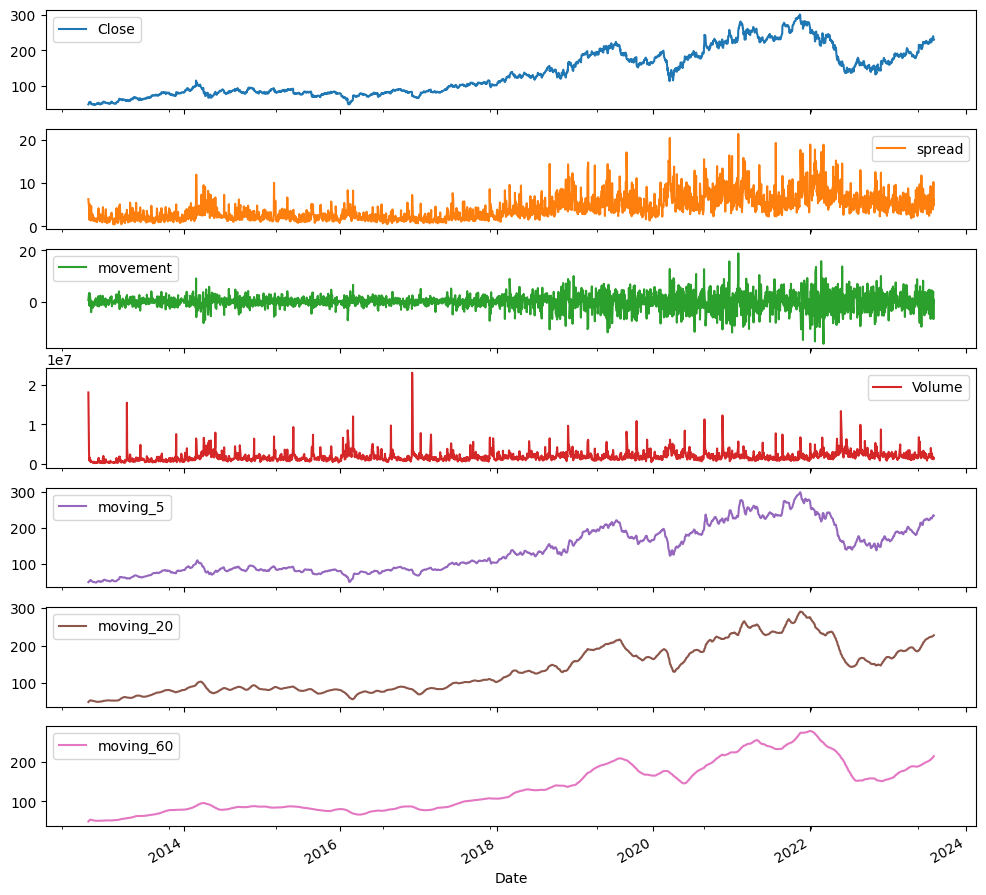

In [5]:

data.plot(subplots=True,figsize=(12, 12))


 ### ^^^ EDA part 2

### EDA Summary

WOW, that's a volatile stock! As the stock became older and older, the volume spikes become more frequent and the spread and movement differences become larger. It's possible that we would consider only looking at the last few months in order to make predictions that are more current. But we won;t do that now.

After EDA and before modeling, we need to split our data. For today, we will use the standard random 80% for training and 20% for testing. We will not concern our selves with other intricacies that present when relying on time series data. We have perfect hindsight, so we will use it to inform our model.


In [6]:
# split the data per the docs

def split_data(df,train_pct):
  column_indices = {name: i for i, name in enumerate(df.columns)}

  df_mean = df.rolling(len(df), min_periods = 1).mean()
  df_std = df.rolling(len(df), min_periods = 1).std().fillna(1)

  df = (df - df_mean) / df_std

  df = df.dropna()

  n = len(df)
  train_df = df[1:int(n*train_pct)]
  test_df = df[int(n*train_pct):]

  num_features = df.shape[1]

  return train_df, test_df, num_features

train_df, test_df, num_features = split_data(data,.8)

## Step 3 : Model Architecture

Reccurrent Neural Networks can be pretty simple. The "hardest" part is getting the data into the appropriate shape, where there is an input set and a label. We can think of the input set as the days leading up to the date in question. For our project we will leverage a really short 5 day window, a mid 22 day window and a longer 90 day window.


More on preprocessing time series data [here](https://www.tensorflow.org/tutorials/structured_data/time_series).


Once our data is transformed into our window tensors, we can shove them into a model. Here we will look at 2 models (named via the layers they use):
1. SimpleRNN
2. LSTM

In an effort to make this project faster, ive simplified the layers on the models and minimized the optimizations. Recall, the focus here is the learning along the way (more on that in the conclusion section).






In [7]:
# make a dict to hold our model results
performance = {}

In [8]:
# this is largely brought over from the docs (they give it to us to use it), but I have added comments to show the learning.

# define an object type to hold ourr data
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])



def split_window(self, features):
  f"""
  This function splits our data into inputs (x) and labels (y)
  """
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  # stack the data -> note the one line for loop ...
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


def make_dataset(self, data):
  f"""
  This function converts our arrays into tensors to be consumed by the model
  """
  data = np.array(data, dtype=np.float32)

  # leverage the tf utility to make a tf dataset from the arrays above
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      )

  ds = ds.map(self.split_window)

  return ds

# convert the dataframes into tf datasets leveraging the function above
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

# call all the functions in order : this is our data pipeline
WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.test = test

Now that we have our helper object and functions, let's call it and make our 3 datasets:

In [9]:
# short 5 day lookback
windowed_data_short = WindowGenerator(input_width=5, label_width=1, shift=1,
                     label_columns=['Close'])

windowed_data_short

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['Close']

In [10]:
# mid range 22 day lookback
windowed_data_mid = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['Close'])

windowed_data_mid

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22]
Label column name(s): ['Close']

In [11]:
# longer 90 day lookback
windowed_data_long = WindowGenerator(input_width=90, label_width=1, shift=1,
                     label_columns=['Close'])

windowed_data_long

Total window size: 91
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [90]
Label column name(s): ['Close']

In [12]:


def compile_and_fit(model, window):
  f"""
  This function takes in our model and dataset, compiles and fits it and returns it's history
  """
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=3,
                                                    mode='min')

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError()
                )

  history = model.fit(window.train, epochs=200,
                      batch_size = 64, callbacks=[early_stopping])

  # clear the output as we don't want alot of lines in this report
  IPython.display.clear_output()

  return history

In [13]:
def model_SimpleRNN(window_data):

  model_srnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, activation='tanh'),
    tf.keras.layers.SimpleRNN(64, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(units = 1)
  ])


  history = compile_and_fit(model_srnn, window_data)

  performance[f'SimpleRNN_{str(window_data.label_indices)}'] = model_srnn.evaluate( window_data.test, verbose=0 )

  return model_srnn

In [14]:
def model_LSTM(window_data):

  model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 64, return_sequences=True, activation='tanh'),
    tf.keras.layers.Dense(units = 1)
  ])


  history = compile_and_fit(model_lstm, window_data)

  performance[f'LSTM_{str(window_data.label_indices)}'] = model_lstm.evaluate( window_data.test, verbose=0 )


  return model_lstm

In [15]:
model_SimpleRNN_short = model_SimpleRNN(windowed_data_short)

In [16]:
model_SimpleRNN_mid = model_SimpleRNN(windowed_data_mid)

In [17]:
model_SimpleRNN_long = model_SimpleRNN(windowed_data_long)

In [18]:
model_LSTM_short = model_LSTM(windowed_data_short)

In [19]:
model_LSTM_mid = model_LSTM(windowed_data_mid)

In [20]:
model_LSTM_long = model_LSTM(windowed_data_long)

### Review

So, to recap, we created 2 models and 3 windowed datasets. This resulted in 6 total models. More on which is best below...

## Step 4 : Results and Analysis

### Analysis



In [21]:
for name, value in performance.items():
  print(f'{name:8s}: {value:0.4f}')

SimpleRNN_[5]: 0.1345
SimpleRNN_[22]: 0.1045
SimpleRNN_[90]: 0.2449
LSTM_[5]: 0.0237
LSTM_[22]: 0.0916
LSTM_[90]: 0.4420


In [22]:
def plot(self, model):
  plt.figure(figsize=(12, 8))
  range = -60

  plt.plot(self.test_df.index[range:], self.test_df['Close'][range:], marker='.', label='Real Price')

  predictions = model.predict(self.test).reshape(-1,)

  plt.plot(self.test_df.index[range:], predictions[range:], marker='X', label='Predictions',c='#ff7f0e')

  plt.xlabel('Date')
  plt.ylabel('Normalized Price')

WindowGenerator.plot = plot

5/5 [==============================] - 1s 25ms/step


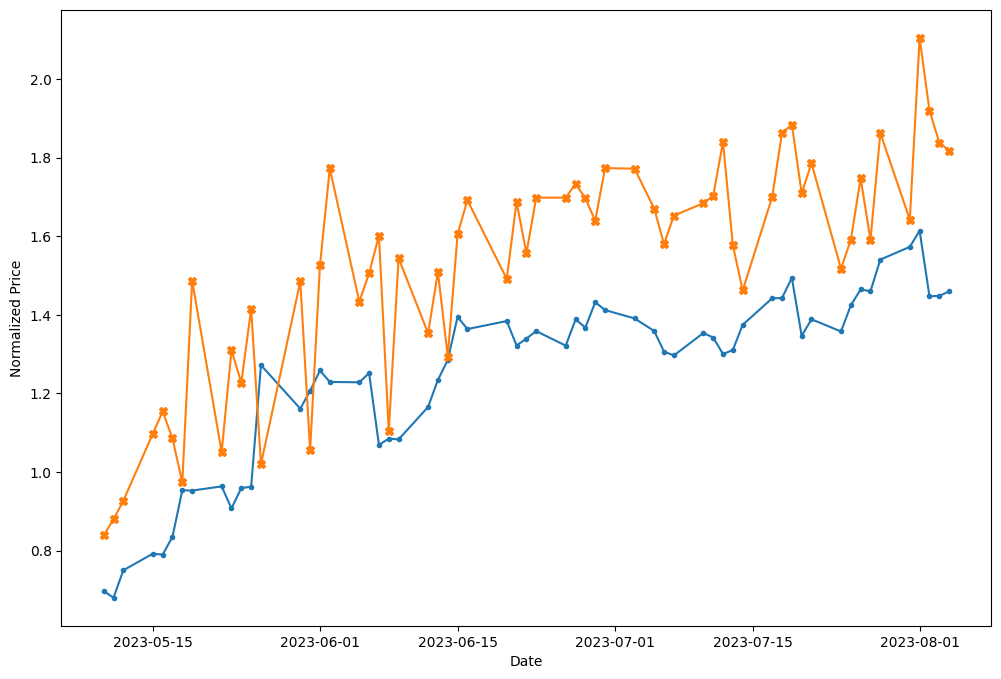

In [25]:
windowed_data_mid.plot(model_SimpleRNN_mid)

5/5 [==============================] - 1s 6ms/step


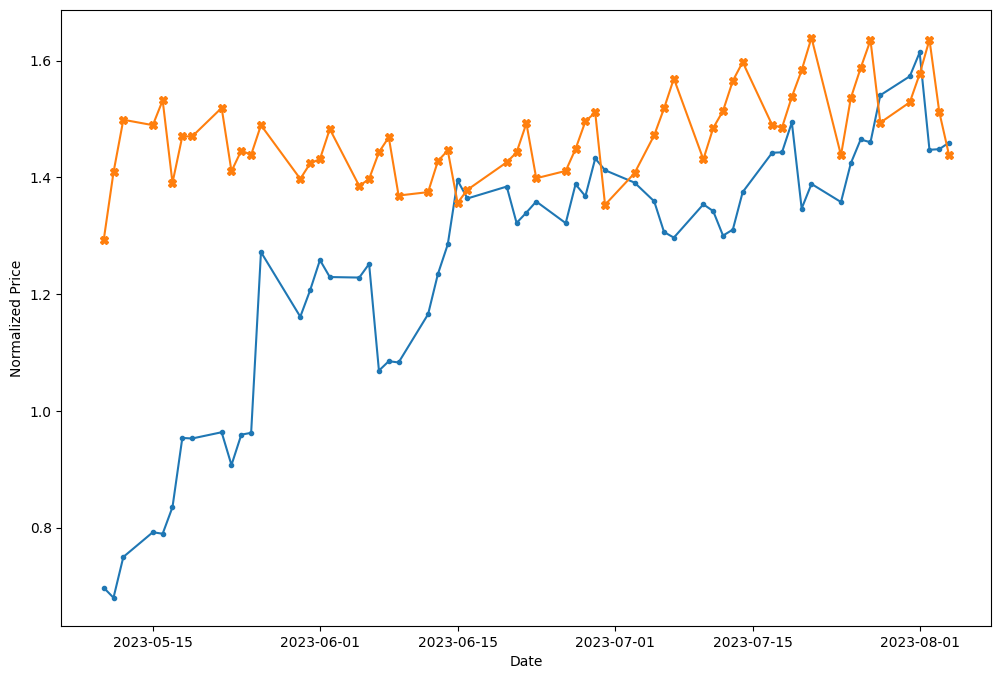

In [ ]:
windowed_data_short.plot(model_LSTM_short)

## Conclusion (and more Analysis)

RNNs are tough, but much faster at training than image data.

Based on the graphs above, we can see that our best SimpleRNN model captured the general increasing trend, but over predicted the value.

We can see that the best LSTM eventually predicted closer values.

#### Learnings:

1. Tensorflow has A LOT of built-in functions to help maniulate data, but you still have to program objects and what not to make repeatability easier.
2. SimpleRNN worked better here than LSTM model
3. Classes can easily be extended to add new attributes via defined functions (I am still very much not a SWE - I prefer the big picture to the nuanced technical)

#### What didn't work:

1. Not normalizing the data. I tried to leave the raw values in the the dataset, but this made all predicted values the same.
2. Making deeper networks. adding additional layers did not dramatically improve the results
3. Making a longer window -> the longer windows performed worse, most likely due to the general increase in value over time.


#### Ways to Improve:

1. Split the data better : Since the first 80% is used for training and the final 20% for testing, the values in the testing set should arguably be used in training as well. In the future, we could take additional steps to work through this piece so that the prediction for yesterday uses all relevant data before yesterday.
2. Try out more models -> these are just 2 example. We should try out many many more models before this is ready for the real world.
3. Add more features. We could add other market conditions to better predict the stock price (possibly data as a more granular level).

